In [1]:
import os
import sqlite3
import json
import random
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm

import torch
import numpy as np
import datasets
import transformers
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollator

/home/glai/anaconda3/envs/subset/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def get_nth_best(n, db_path):
    try:
        con = sqlite3.connect(db_path)
        cur = con.cursor()
        cur.execute("SELECT * FROM states ORDER BY objective DESC LIMIT 1 OFFSET %d" % n)
        r = cur.fetchone()
    finally:
        con.close()
    return (np.array(json.loads(r[0])), r[1], r[2])


def evaluate(model, val_dataloader, metric, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        model.eval()
        val_pbar = tqdm(total=len(val_dataloader))
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])
            val_pbar.update(1)
        eval_dict = metric.compute()
        val_pbar.set_description('Acc: %.2f' % eval_dict['accuracy'])
        return eval_dict

In [ ]:
############# LOAD MODEL #################
PATH = "/home/glai/dev/subset-active-learning/local_bucket/7000_model.pt"
model = torch.load(PATH)

In [91]:
############# GET POOL CONFIDENCE SCORES #################
from subset_active_learning.subset_selection import preprocess
tokenized_sst2 = preprocess.preprocess_sst2(model_card="roberta-base")
sst2_downsample = tokenized_sst2['train'].shuffle(seed=0).select(range(0, 1000))
train_dataloader = torch.utils.data.DataLoader(sst2_downsample, shuffle=False, batch_size=8, pin_memory=True)
pool_scores = evaluate(model, train_dataloader, score=True)['scores'].cpu().numpy()

  0%|          | 0/125 [00:00<?, ?it/s]

/tmp/ipykernel_30482/1429344335.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_scores = torch.nn.Softmax()(logits)[:,-1]


In [154]:
subset_indices, preds, obj = get_nth_best(100); subset_indices

In [ ]:
select_scores = pool_scores[subset_indices]

<AxesSubplot:ylabel='Probability'>

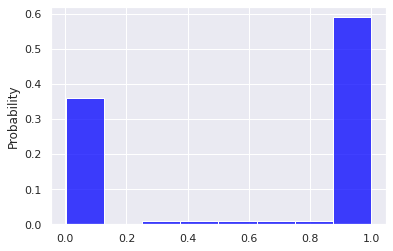

In [155]:
# sns.histplot(select_scores, stat='probability', color='blue', bins=8)
# sns.histplot(np.random.choice(pool_scores, 100, replace=False), stat='probability', color='orange', bins=8)
# sns.histplot(pool_scores, stat='probability', color='orange', bins=8)

In [76]:
# does distribution entropy correlate with accuracy?
# we can check with the database